In [37]:
import numpy as np
import imageio
from softlearning.models.state_estimation import (
    state_estimator_model, get_dumped_pkl_data, get_seed_data, train)
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_shape = (32, 32, 3)

obs_keys = ('object_position',
            'object_orientation_cos',
            'object_orientation_sin')
model = state_estimator_model(
    domain='DClaw',
    task='TurnFreeValve3ResetFreeSwapGoal-v0',
    obs_keys_to_estimate=obs_keys, 
    input_shape=image_shape)

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='mean_squared_error')

W0814 18:23:19.984154 140503085561664 deprecation.py:506] From /opt/conda/envs/vice/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "state_estimator_preprocessor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
convnet_preprocessor (Pickla (None, 256)               112576    
_________________________________________________________________
feedforward_model (Picklable (None, 4)                 132612    
Total params: 245,188
Trainable params: 245,188
Non-trainable params: 0
_________________________________________________________________


Train on 475047 samples, validate on 25003 samples
Epoch 1/5
475047/475047 [==============================] - 46s 96us/sample - loss: 0.4226 - val_loss: 0.0078
Epoch 2/5
475047/475047 [==============================] - 42s 89us/sample - loss: 0.0052 - val_loss: 0.0042
Epoch 3/5
475047/475047 [==============================] - 43s 91us/sample - loss: 0.0038 - val_loss: 0.0034
Epoch 4/5
475047/475047 [==============================] - 42s 89us/sample - loss: 0.0031 - val_loss: 0.0026
Epoch 5/5
475047/475047 [==============================] - 42s 89us/sample - loss: 0.0027 - val_loss: 0.0030

========== IMAGE # 0 =========
POS ERROR (cm): 0.48182654693532556 true xy: [ 0.71230762 -0.14425135] pred xy: [ 0.7068149 -0.1548195]
ANGLE ERROR (degrees): 1.9625827391296227 true angle: -130.2219180039654 pred angle: -132.18450074309504

========== IMAGE # 1 =========
POS ERROR (cm): 2.449980202814006 true xy: [0.70847127 0.54922796] pred xy: [0.7237085  0.61565673]
ANGLE ERROR (degrees): 1.066576

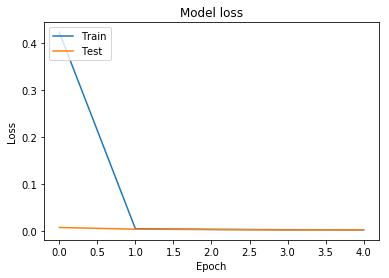

In [3]:
train(model, obs_keys, './state_estimator_test.h5', n_epochs=5)

In [13]:
weights_path = './state_estimator_random_data_50_epochs.h5'
# weights_path = './state_estimator_test.h5'
model.load_weights(weights_path)

In [21]:
training_pools_base_path = '/root/softlearning-vice/goal_classifier/free_screw_state_estimator_data/all_data.pkl' 
images, labels = get_dumped_pkl_data(training_pools_base_path)
# images, labels = get_training_data(training_pools_base_path, limit=1)

In [38]:
training_pools_base_path = '/home/justinvyu/ray_results/gym/DClaw/TurnFreeValve3ResetFreeSwapGoal-v0/2019-08-07T14-57-41-state_gtr_2_goals_with_resets_regular_box_saving_pixels_fixed_env/id=612875d0-seed=9463_2019-08-07_14-57-42op75_8n7'
images, labels = get_seed_data(training_pools_base_path)

ValueError: need at least one array to concatenate

In [27]:
random_indices = np.random.randint(images.shape[0], size=10000)
test_images = images[random_indices]
test_labels = labels[random_indices]
preds = model.predict(test_images)

In [28]:
pos_errors = []
angle_errors = []

degrees = lambda x: x * 180 / np.pi
def angle_distance(deg1, deg2):
    phi = np.abs(deg1 - deg2) % 360
    distance = 360 - phi if phi > 180 else phi
    return distance

for i, (test_img, label, pred) in enumerate(zip(test_images, test_labels, preds)):
    pos_error_xy = np.abs(label[:2] - pred[:2])
    pos_error = np.linalg.norm(pos_error_xy)
    pos_error = 15 * pos_error # free box is 30 cm, 15 on each side (-1 -> 1 --> -15 -> 15)
    
    true_angle = np.arctan2(label[3], label[2])
    true_angle = degrees(true_angle)
    pred_angle = np.arctan2(pred[3], pred[2])
    pred_angle = degrees(pred_angle)
    
    angle_error = angle_distance(true_angle, pred_angle)

    pos_errors.append(pos_error)
    angle_errors.append(angle_error)

#     print('\n========== IMAGE #', i, '=========')
#     print('POS ERROR (cm):', pos_error, 'true xy: {}'.format(label[:2]), 'pred xy: {}'.format(pred[:2]))
#     print('ANGLE ERROR (degrees):', angle_error, 'true angle: {}'.format(true_angle), 'pred angle: {}'.format(pred_angle))
#     imageio.imwrite(f'/root/imgs/test{i}.jpg', test_img)

mean_pos_error = np.mean(pos_errors)
mean_angle_error = np.mean(angle_errors)
print('MEAN POS ERROR (CM):', mean_pos_error)
print('MEAN ANGLE ERROR (degrees):', mean_angle_error)

MEAN POS ERROR (CM): 0.4343386054755896
MEAN ANGLE ERROR (degrees): 1.345682137380202



========== IMAGE # 0 =========
POS ERROR (cm): 5.536779241042964

true: [-0.33909363 -1.2547862   0.40098211  0.91608588]
pred: [-0.2126936  -0.90798426  0.12395909  0.73695004]


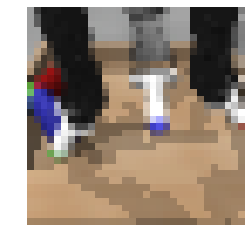


========== IMAGE # 1 =========
POS ERROR (cm): 5.018615353382955

true: [-1.28428253  0.04372109  0.55722549 -0.83036122]
pred: [-0.96614236  0.14729151  0.5358631  -0.8665463 ]


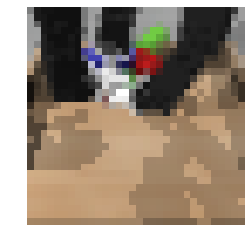


========== IMAGE # 2 =========
POS ERROR (cm): 4.747022632936132

true: [ 1.20351447 -0.11722019  0.58665661 -0.8098358 ]
pred: [ 0.88830954 -0.14546834  0.6907401  -0.65055573]


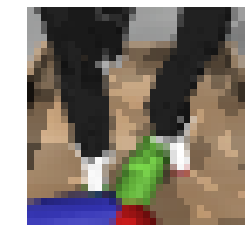


========== IMAGE # 3 =========
POS ERROR (cm): 4.530676535223736

true: [-0.54108789 -1.06383382  0.73373772 -0.67943282]
pred: [-0.5835895  -0.76479393  0.7353314  -0.7463719 ]


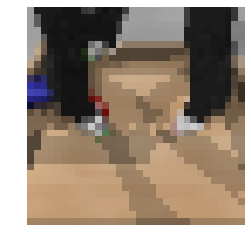


========== IMAGE # 4 =========
POS ERROR (cm): 3.807970367835558

true: [ 1.19962909  0.18645567 -0.99697145 -0.07776846]
pred: [ 0.9535916   0.12390309 -0.86141413  0.05835346]


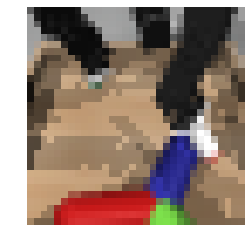


========== IMAGE # 5 =========
POS ERROR (cm): 3.640572900707216

true: [1.16263377 0.40211072 0.79146439 0.61121528]
pred: [0.96831834 0.54753137 0.7943833  0.7583433 ]


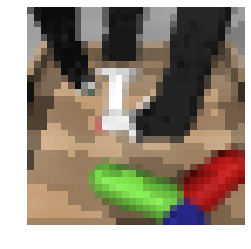


========== IMAGE # 6 =========
POS ERROR (cm): 3.5953772704975266

true: [ 0.24705453 -1.1746237   0.71488286 -0.69924423]
pred: [ 0.2712654  -0.93615776  0.73389065 -0.6313696 ]


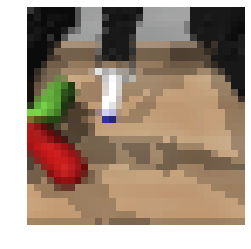


========== IMAGE # 7 =========
POS ERROR (cm): 3.3111630142820507

true: [-0.94170011 -0.3337157   0.87091725 -0.4914297 ]
pred: [-0.8205683  -0.14917548  0.7385886  -0.34116995]


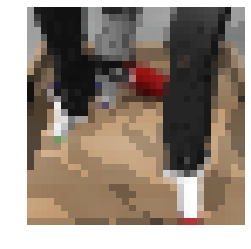


========== IMAGE # 8 =========
POS ERROR (cm): 2.757271165350016

true: [1.06585074 0.47797877 0.90111755 0.43357487]
pred: [0.9222762  0.59276307 0.89524627 0.47431546]


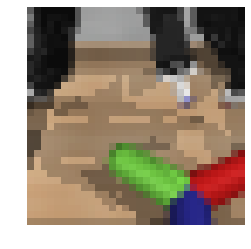


========== IMAGE # 9 =========
POS ERROR (cm): 2.745443783643753

true: [-1.11060089  0.36772421 -0.34331242 -0.93922126]
pred: [-0.93916935  0.43184173 -0.3387417  -0.9368118 ]


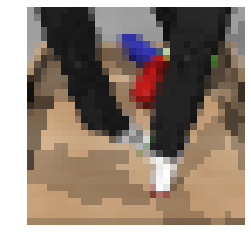


========== IMAGE # 10 =========
POS ERROR (cm): 2.6202778281767776

true: [-0.9797828  -0.60651617  0.0344903   0.99940503]
pred: [-0.8156401  -0.54674923 -0.0048552   0.8963028 ]


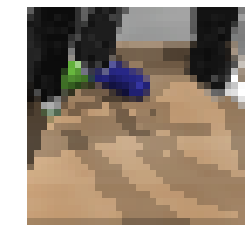


========== IMAGE # 11 =========
POS ERROR (cm): 2.570370651062014

true: [-5.48697824e-01  8.99977820e-01 -9.99999995e-01 -9.95170012e-05]
pred: [-0.47659254  0.7445288  -0.94167167  0.03260161]


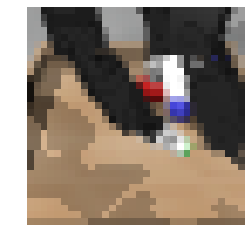


========== IMAGE # 12 =========
POS ERROR (cm): 2.5318326373123874

true: [-0.32765438 -0.15413774 -0.18981323 -0.98182022]
pred: [-0.4640841  -0.05475662 -0.24724735 -0.7837097 ]


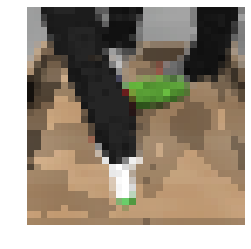


========== IMAGE # 13 =========
POS ERROR (cm): 2.5268024893281322

true: [-0.54841154  1.03045854  0.84528146 -0.53432131]
pred: [-0.5113157   0.8661403   0.84369195 -0.5440957 ]


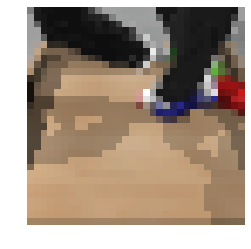


========== IMAGE # 14 =========
POS ERROR (cm): 2.5185800981383593

true: [-0.90040726 -0.32477814  0.00333661 -0.99999443]
pred: [-0.80018497 -0.19006476 -0.45783395 -0.73439395]


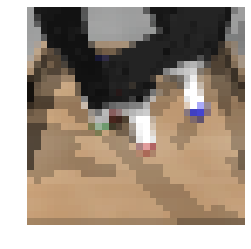


========== IMAGE # 15 =========
POS ERROR (cm): 2.4969819294270663

true: [-1.07212975  0.00819229 -0.64299094 -0.76587379]
pred: [-0.93346745 -0.08391371 -0.6446014  -0.83311695]


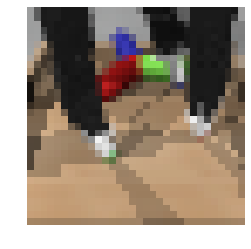


========== IMAGE # 16 =========
POS ERROR (cm): 2.3380376866874784

true: [-0.58452185 -0.02769381  0.94343416  0.33155992]
pred: [-0.70763147 -0.12329309  0.922303    0.2433898 ]


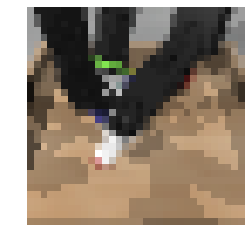


========== IMAGE # 17 =========
POS ERROR (cm): 2.218866864835664

true: [-0.95019539 -0.356756    0.83425954 -0.55137195]
pred: [-0.85809255 -0.2410032   0.8222568  -0.5723725 ]


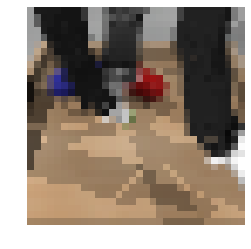


========== IMAGE # 18 =========
POS ERROR (cm): 2.1935993157965323

true: [-0.94319475 -0.56375037  0.13781047  0.99045862]
pred: [-0.79860306 -0.58564484  0.135089    0.90781045]


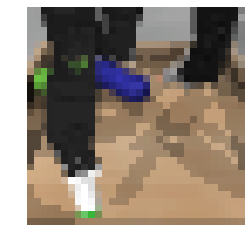


========== IMAGE # 19 =========
POS ERROR (cm): 2.1566303424122153

true: [-0.79206164  0.43499318 -0.93911791  0.34359504]
pred: [-0.80647475  0.2919421  -0.8223475   0.46601397]


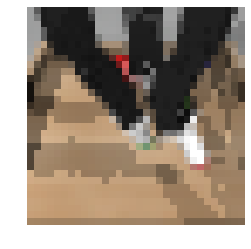

In [29]:
def display_top_errors(errors, label_str=""):
    errors = np.array(errors)
    ind = np.argpartition(errors, -20)[-20:]
    ind = ind[np.argsort(errors[ind])]
    ind = np.flip(ind) # Order descending
    top_errors = errors[ind]
    
    top_error_imgs, top_error_labels, top_error_preds = test_images[ind], test_labels[ind], preds[ind]
    for i, (error, img, label, pred) in enumerate(zip(top_errors,
                                                      top_error_imgs,
                                                      top_error_labels,
                                                      top_error_preds)):
        print('\n========== IMAGE #', i, '=========')
        plt.axis('off')
        plt.imshow(img)
        print('{} ERROR (cm): {}\n\ntrue: {}\npred: {}'.format(label_str, error, label, pred))
        plt.show()
    
display_top_errors(pos_errors, label_str="POS")


========== IMAGE # 0 =========
ANGLE ERROR (cm): 32.1313061445497

true: [-0.90040726 -0.32477814  0.00333661 -0.99999443]
pred: [-0.80018497 -0.19006476 -0.45783395 -0.73439395]


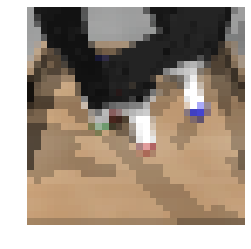


========== IMAGE # 1 =========
ANGLE ERROR (cm): 14.091499662687653

true: [-0.33909363 -1.2547862   0.40098211  0.91608588]
pred: [-0.2126936  -0.90798426  0.12395909  0.73695004]


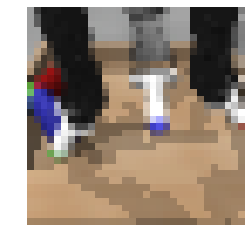


========== IMAGE # 2 =========
ANGLE ERROR (cm): 12.079059450058764

true: [ 0.95929861 -0.15549056 -0.28062373 -0.95981786]
pred: [ 0.87228525 -0.04501012 -0.07191478 -0.9750121 ]


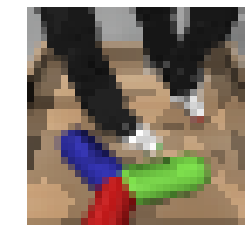


========== IMAGE # 3 =========
ANGLE ERROR (cm): 11.975105761058785

true: [-0.64439099 -0.44531738 -0.53997765  0.84167935]
pred: [-0.52524483 -0.3989047  -0.3517567   0.9305524 ]


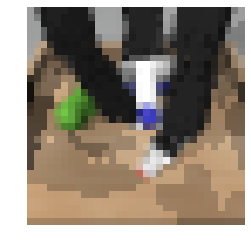


========== IMAGE # 4 =========
ANGLE ERROR (cm): 11.972151713088692

true: [-0.56083384  0.03118904 -0.18275123  0.98315919]
pred: [-0.57589316  0.0185555  -0.37410286  0.90306574]


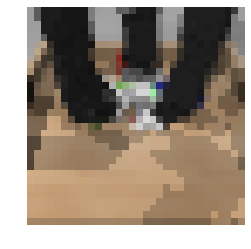


========== IMAGE # 5 =========
ANGLE ERROR (cm): 10.795923907378722

true: [ 1.20351447 -0.11722019  0.58665661 -0.8098358 ]
pred: [ 0.88830954 -0.14546834  0.6907401  -0.65055573]


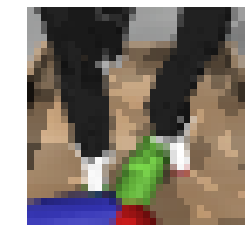


========== IMAGE # 6 =========
ANGLE ERROR (cm): 10.39886311603512

true: [-0.94676246 -0.43239285  0.81736236 -0.57612393]
pred: [-0.865074   -0.36533386  0.75006795 -0.3462547 ]


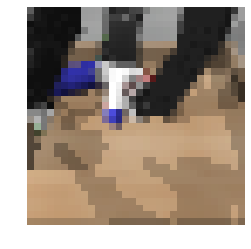


========== IMAGE # 7 =========
ANGLE ERROR (cm): 9.65830300806671

true: [-0.68716705 -0.24560393  0.33543601 -0.94206299]
pred: [-0.74416476 -0.33719265  0.16910765 -0.9648909 ]


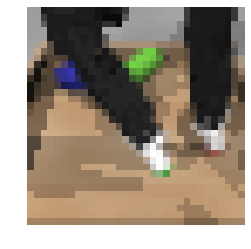


========== IMAGE # 8 =========
ANGLE ERROR (cm): 9.548283806037137

true: [ 1.0844426  -0.16659487  0.84993772  0.52688317]
pred: [ 0.9681441 -0.1454281  0.7564949  0.6656127]


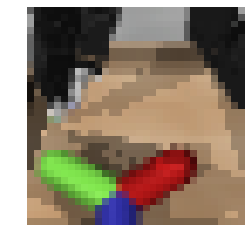


========== IMAGE # 9 =========
ANGLE ERROR (cm): 9.487949318086862

true: [-0.0748326   0.63899727 -0.98919589 -0.14659979]
pred: [-0.04572045  0.739936   -0.93332744  0.0172368 ]


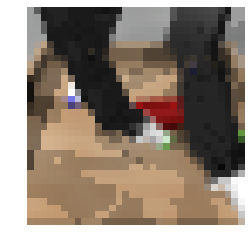


========== IMAGE # 10 =========
ANGLE ERROR (cm): 9.44362009982072

true: [-0.79206164  0.43499318 -0.93911791  0.34359504]
pred: [-0.80647475  0.2919421  -0.8223475   0.46601397]


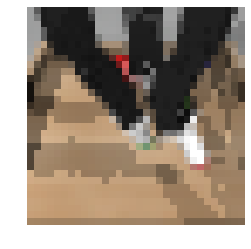


========== IMAGE # 11 =========
ANGLE ERROR (cm): 8.722949002600927

true: [-0.45964595  0.2418762   0.16402756 -0.98645576]
pred: [-0.38187575  0.2639684   0.3101036  -0.9452035 ]


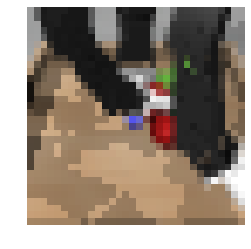


========== IMAGE # 12 =========
ANGLE ERROR (cm): 8.682248164592949

true: [-0.80366671 -0.16526213 -0.91902089  0.39420883]
pred: [-0.77218926 -0.0578992  -0.90565026  0.23479722]


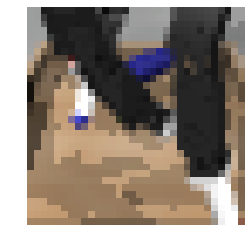


========== IMAGE # 13 =========
ANGLE ERROR (cm): 8.667622429660625

true: [-0.69569747  0.52430286 -0.37817451 -0.92573433]
pred: [-0.68361443  0.57378566 -0.23021981 -0.95503926]


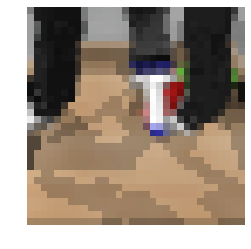


========== IMAGE # 14 =========
ANGLE ERROR (cm): 8.56666408447164

true: [-0.57579126 -0.11512447  0.28943166  0.95719868]
pred: [-0.55813575 -0.04642392  0.42966306  0.90525174]


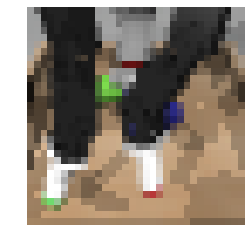


========== IMAGE # 15 =========
ANGLE ERROR (cm): 8.355976652637239

true: [-0.64028365 -0.00427463 -0.49341784 -0.86979241]
pred: [-0.6260299  0.0072744 -0.6293398 -0.8077984]


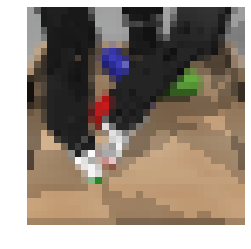


========== IMAGE # 16 =========
ANGLE ERROR (cm): 8.335684253237105

true: [ 1.19962909  0.18645567 -0.99697145 -0.07776846]
pred: [ 0.9535916   0.12390309 -0.86141413  0.05835346]


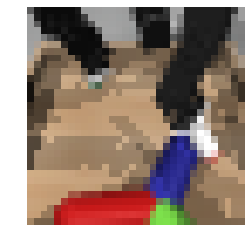


========== IMAGE # 17 =========
ANGLE ERROR (cm): 8.232302808837659

true: [-0.553562   -0.10981886 -0.27453851 -0.96157611]
pred: [-0.5806463  -0.13038518 -0.41292912 -0.920234  ]


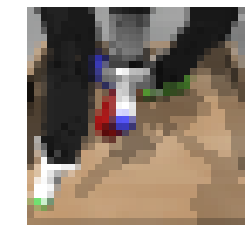


========== IMAGE # 18 =========
ANGLE ERROR (cm): 8.074002047945385

true: [-0.77761509  0.10914104 -0.94639942  0.32299868]
pred: [-0.83090794  0.0450004  -0.8820431   0.4478417 ]


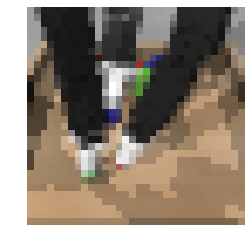


========== IMAGE # 19 =========
ANGLE ERROR (cm): 8.022003747361552

true: [-0.50158856 -0.01221388 -0.53534329 -0.84463457]
pred: [-0.52047867  0.00815159 -0.6458888  -0.75920683]


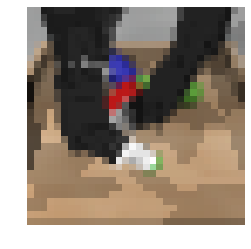

In [30]:
display_top_errors(angle_errors, label_str="ANGLE")

In [11]:
first = np.arctan2(-0.23606753, -0.97173665)
second = np.arctan2(0.17438738, -0.9635754)
rad_to_deg = lambda x: 180 * x / np.pi
rad_to_deg(first), rad_to_deg(second)

(-166.34544160951023, 169.74167643493442)

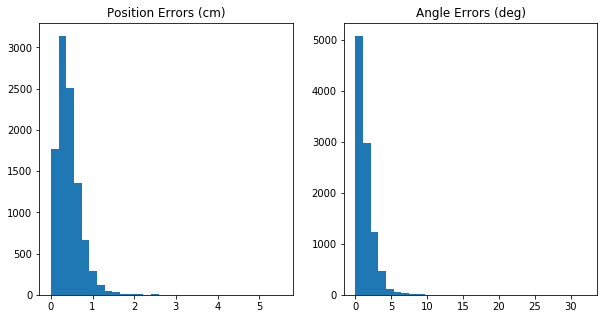

In [31]:
def plot_histograms(pos_errors, angle_errors):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Position Errors (cm)')
    plt.hist(pos_errors, bins=30)
    plt.subplot(1, 2, 2)
    plt.title('Angle Errors (deg)')
    plt.hist(angle_errors, bins=30)
    plt.show()
    
plot_histograms(pos_errors, angle_errors)

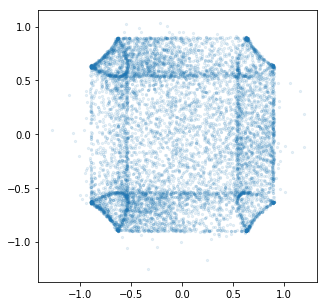

In [36]:
def plot_support():
    plt.figure(figsize=(5, 5))
    plt.scatter(test_labels[:, 0], test_labels[:, 1], alpha=0.1, s=5)
    plt.show()
    
plot_support()